# 第十二週：BERT (Encoder-only-model)
<br>
本週課程為「BERT (Encoder-only-model)」，主要會介紹不同 BERT 相關下游任務的程式碼應用，學習目標著重在如何使用 BERT 相關資源（例如網路上別人訓練好的 BERT 模型）來達成 Token classification、Sequence classification 以及 Text Clustering 等等相關文字處理任務。

### 大綱：
1. 套件介紹
2. 資料前處理
3. Token classification<br>
  3.1 NER<br>
4. Sequence classification<br>
  4.1 Sentiment Classification<br>
  4.2 Relation Extraction (RE)<br>
5. Text Clustering<br>
  5.1 BERTopic 基本用法介紹<br>
  5.2 BERTopic 的 Embedding model<br>
  5.3 BERTopic 的 Clustering model<br>
  5.4 套用中文資料



### 1. 套件介紹

連接雲端資料夾

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/week12') # 請將這行修改為自己的 google drive 路徑
os.listdir() # 確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['raw_data', 'dict', 'TaipeiSansTCBeta-Regular.ttf', 'week12_bert.ipynb']

前處理常用套件

In [ ]:
!pip install jieba

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

transformers 和 Sentence-transformers （使用 huggingface 模型）

In [ ]:
!pip install sentence_transformers
!pip install ckip_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

BERTopic

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.2 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039293 sha256=1e50ebad71c3632799a4b0a8fc01c9da64b0cb32b0f1492a463fed014881b3fe
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Succes

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

載入「周處除三害」資料集

In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/movie_1.csv')

In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)
metaData['sentence'] = metaData['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)


metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影
1,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,開播前照慣例都會放過幾天要上映的預告片
2,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,之前加減都會放些國外的預告片
3,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,結果昨天播了三部電影預告片全部都是臺灣國產
4,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,周處除三害女鬼橋動物感傷の清晨
...,...,...,...,...,...,...
9637,599,https://www.ptt.cc/bbs/movie/M.1711285886.A.3D...,Re:[普負雷]要cult不cult的周處除三害,2024-03-24 21:11:24,1.cult片沒有定義啦\n很多電影是後來才被大家認定是cult片\n甚至不少電影當初是當作...,所以最後本來是嚴肅殘忍血腥的大屠殺轉眼變成歡樂輕鬆的大解放觀眾看得完全沒有壓力只有滿滿的爽快
9638,599,https://www.ptt.cc/bbs/movie/M.1711285886.A.3D...,Re:[普負雷]要cult不cult的周處除三害,2024-03-24 21:11:24,1.cult片沒有定義啦\n很多電影是後來才被大家認定是cult片\n甚至不少電影當初是當作...,這很cult啊大屠殺拍得這麼輕鬆當然cult啊不然呢
9639,599,https://www.ptt.cc/bbs/movie/M.1711285886.A.3D...,Re:[普負雷]要cult不cult的周處除三害,2024-03-24 21:11:24,1.cult片沒有定義啦\n很多電影是後來才被大家認定是cult片\n甚至不少電影當初是當作...,3.周處前面其實拍的蠻嚴肅緊張的但到後來大屠殺實在太歡樂終於露出真面目就是拍來惡搞的
9640,599,https://www.ptt.cc/bbs/movie/M.1711285886.A.3D...,Re:[普負雷]要cult不cult的周處除三害,2024-03-24 21:11:24,1.cult片沒有定義啦\n很多電影是後來才被大家認定是cult片\n甚至不少電影當初是當作...,類似的電影大概就浴血任務2本來前面拍得好好的熱血動作片羅禮士出場後就完全變調了變得超歡樂完全...


載入傲慢與偏見（已斷句）

In [ ]:
# 讀入英文示範資料集
en_origin_data = pd.read_csv('./raw_data/en_sentence_chapter.csv')
en_origin_data.head()

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
1,"It is a truth universally acknowledged, that a...",1
2,However little known the feelings or views of ...,1
3,"""My dear Mr. Bennet,"" said his lady to him one...",1
4,Mr. Bennet replied that he had not.,1


### 3. Token classification

#### 3.1 NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

如果找不到自己適用的模型的話，也可以透過 fine-tune 來建立自己的模型。<br>
本課程因為時間與資源因素，僅針對「如何使用網路上他人 fine-tune 好的模型」進行程式碼示範，不提供 fine-tune 程式碼範例。<br>
如有需要，可參考 Huggingface 相關教學文章：[Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)

中文 NER：<br>
使用套件：transformers<br>
使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipe = pipeline('ner', model=model, tokenizer=tokenizer)
example = ["到底是哪三害？有沒有周處除三害的八卦？"]

ner_results = ner_pipe(example)
ner_results

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

[[]]

使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 初始化 ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

# 想要進行處理的句子
text = [
   "昨天去電影院看周處除三害，說看過的國片裡面第一名的，超好看的，所以我大膽預測會破億，還沒看的趕快去看。",
   "由阮經天主演的電影《周處除三害》，上映首週全台票房就突破1600萬元，更一舉入圍金馬獎7項提名，創下亮眼成績。不過知名導演錢人豪13日發文指控，該片與他構思多年的劇本《無法無天》有諸多相似之處。"
]

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Inference: 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]


In [ ]:
# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

# 顯示處理結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   print(sentence)
   print(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   for entity in sentence_ner:
      print(entity)
   print()

昨天去電影院看周處除三害，說看過的國片裡面第一名的，超好看的，所以我大膽預測會破億，還沒看的趕快去看。
昨天(Nd)　去(VCL)　電影院(Nc)　看(VC)　周處(Nb)　除(VC)　三(Neu)　害(Na)　，(COMMACATEGORY)　說(VE)　看過(VC)　的(DE)　國片(Na)　裡面(Ncd)　第一(Neu)　名(Nf)　的(DE)　，(COMMACATEGORY)　超(Dfa)　好看(VH)　的(T)　，(COMMACATEGORY)　所以(Cbb)　我(Nh)　大膽(VH)　預測(VE)　會(D)　破億(VHC)　，(COMMACATEGORY)　還(D)　沒(D)　看(VC)　的(DE)　趕快(D)　去(D)　看(VE)　。(PERIODCATEGORY)
NerToken(word='昨天', ner='DATE', idx=(0, 2))
NerToken(word='第一', ner='ORDINAL', idx=(21, 23))
NerToken(word='億', ner='CARDINAL', idx=(40, 41))

由阮經天主演的電影《周處除三害》，上映首週全台票房就突破1600萬元，更一舉入圍金馬獎7項提名，創下亮眼成績。不過知名導演錢人豪13日發文指控，該片與他構思多年的劇本《無法無天》有諸多相似之處。
由(P)　阮經天(Nb)　主演(VC)　的(DE)　電影(Na)　《(PARENTHESISCATEGORY)　周處(Nb)　除(P)　三(Neu)　害(Na)　》(PARENTHESISCATEGORY)　，(COMMACATEGORY)　上映(VAC)　首(Nes)　週(Nf)　全(Neqa)　台(Nc)　票房(Na)　就(D)　突破(VC)　1600萬(Neu)　元(Nf)　，(COMMACATEGORY)　更(Dfa)　一舉(D)　入圍(VJ)　金馬獎(Nb)　7(Neu)　項(Nf)　提名(VC)　，(COMMACATEGORY)　創下(VC)　亮眼(VH)　成績(Na)　。(PERIODCATEGORY)　不過(Cbb)　知名(VH)　導演(Na)　錢人豪(Nb)　13日(Neu)　發文(VC)　指控(VE)　，(COMMACATEGORY)　該(Nes)　片(Nf)　與(P)　他(Nh)　構思(VE)　

透過POS和NER，我們識別了幾個關鍵entity，如「阮經天」被標記為PERSON，而「周處除三害」這部電影則被標記為WORK_OF_ART。這幫助我們更精確地理解文本內容！

套用到我們先前處理好的資料集

In [ ]:
if isinstance(text, float):
    text = str(text)  # 將浮點數轉換為字符串
elif isinstance(text, list):
    text = [str(item) if isinstance(item, float) else item for item in text]  # 處理列表中的浮點數

In [ ]:

text = [str(sentence) for sentence in metaData['sentence'].tolist()]
# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results


Inference: 100%|██████████| 48/48 [06:06<00:00,  7.63s/it]


,sentence,packed_sentence,entities
0,昨天去看我們金馬男神阮經天演的電影,昨天(Nd) 去(D) 看(VC) 我們(Nh) 金馬(Na) 男神(Na) 阮經天(Nb)...,"[NerToken(word='昨天', ner='DATE', idx=(0, 2)), ..."
1,開播前照慣例都會放過幾天要上映的預告片,開播(VA) 前(Ng) 照(P) 慣例(Na) 都(D) 會(D) 放過(VC) 幾(Ne...,"[NerToken(word='幾天', ner='DATE', idx=(10, 12))]"
2,之前加減都會放些國外的預告片,之前(Nd) 加減(VC) 都(D) 會(D) 放(VC) 些(Nf) 國外(Nc) 的(D...,[]
3,結果昨天播了三部電影預告片全部都是臺灣國產,結果(Dk) 昨天(Nd) 播(VC) 了(Di) 三(Neu) 部(Nf) 電影(Na) ...,"[NerToken(word='昨天', ner='DATE', idx=(2, 4)), ..."
4,周處除三害女鬼橋動物感傷の清晨,周處(Nb) 除(P) 三(Neu) 害(Na) 女鬼橋(Nc) 動物(Na) 感傷(VK)...,[]
...,...,...,...
12283,類似的電影大概就浴血任務2本來前面拍得好好的熱血動作片羅禮士出場後就完全變調了變得超歡樂完全...,類似(VG) 的(DE) 電影(Na) 大概(D) 就(D) 浴血(VCL) 任務(Na) ...,"[NerToken(word='浴血任務2', ner='WORK_OF_ART', idx..."
12284,4.酒瓶砸小弟頭那段我覺得也是致敬另一部cult片北野武的3-4x10月https://yo...,4.(Cbb) 酒瓶(Na) 砸(VC) 小弟(Na) 頭(Na) 那(Nep) 段(Nf)...,"[NerToken(word='北野武', ner='PERSON', idx=(25, 2..."
12285,si=eOPCk3cxtq-OKLmX這段非常有名,si=eOPCk3cxtq-OKLmX(FW) 這(Nep) 段(Nf) 非常(Dfa) 有...,[]
12286,一鏡到底北野武就這樣若無其事的拿酒瓶砸頭這片段是很震撼的因為觀眾不可能在其他電影看過這種橋段...,一(Neu) 鏡(Na) 到底(D) 北野武(Nb) 就(D) 這樣(Dfa) 若無其事(V...,[]


可以依據前幾週的程式碼，對 NER 後的句子進行近一步的探索

注意：不同的 NER 模型因為 fine-tune 的方法與資料不相同，所以不同的 NER 模型間，Entity Types 不一定相同。<br>
以使用醫學領域資料 fine-tune 的 NER 模型為例：https://huggingface.co/Clinical-AI-Apollo/Medical-NER

英文 NER：<br>
使用套件：transformers<br>
使用的 NER 模型：https://huggingface.co/dslim/bert-large-NER

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]

ner_results = nlp(example)
ner_results

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[{'entity': 'B-PER',
   'score': 0.9971501,
   'index': 4,
   'word': 'Wolfgang',
   'start': 11,
   'end': 19},
  {'entity': 'B-LOC',
   'score': 0.9986046,
   'index': 9,
   'word': 'Berlin',
   'start': 34,
   'end': 40}],
 [{'entity': 'B-PER',
   'score': 0.99876034,
   'index': 1,
   'word': 'Obama',
   'start': 0,
   'end': 5},
  {'entity': 'B-LOC',
   'score': 0.9994566,
   'index': 4,
   'word': 'USA',
   'start': 12,
   'end': 15}]]

### 4. Sequence classification

#### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒：<br>
1: Semi-negation<br>
2: Negation<br>
3: Neutral<br>
4: Semi-positive<br>
5: Positive

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name)

# 使用模型來進行情緒分析
text = ["我喜歡這部電影！", "《周處除三害》是一部2023年台灣犯罪片"]
result = model(text)

# 輸出結果
result


config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'star 4', 'score': 0.4818800389766693},
 {'label': 'star 4', 'score': 0.7132015228271484}]

In [ ]:
import pandas as pd
from transformers import pipeline

# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"
model = pipeline('sentiment-analysis', model=model_name)

# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義情緒分析函數
def analyze_sentiment(sentence):
    try:
        if pd.notna(sentence) and sentence.strip():  # 檢查句子是否為非空
            result = model(sentence)  # 使用 pipeline 進行情緒分析
            label = result[0]['label']
            score = result[0]['score']
            return pd.Series([label, score], index=['label', 'score'])
        else:
            return pd.Series([None, None], index=['label', 'score'])  # 空句子返回空值
    except Exception as e:
        return pd.Series([f"Error: {str(e)}", 0], index=['label', 'score'])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df

,sentence,label,score
0,昨天去看我們金馬男神阮經天演的電影,star 4,0.465051
1,開播前照慣例都會放過幾天要上映的預告片,star 3,0.447717
2,之前加減都會放些國外的預告片,star 4,0.538027
3,結果昨天播了三部電影預告片全部都是臺灣國產,star 2,0.418534
4,周處除三害女鬼橋動物感傷の清晨,star 4,0.728544
...,...,...,...
12283,類似的電影大概就浴血任務2本來前面拍得好好的熱血動作片羅禮士出場後就完全變調了變得超歡樂完全...,star 4,0.663903
12284,4.酒瓶砸小弟頭那段我覺得也是致敬另一部cult片北野武的3-4x10月https://yo...,star 4,0.811095
12285,si=eOPCk3cxtq-OKLmX這段非常有名,star 4,0.661999
12286,一鏡到底北野武就這樣若無其事的拿酒瓶砸頭這片段是很震撼的因為觀眾不可能在其他電影看過這種橋段...,star 4,0.629726


In [ ]:
# 看一下情緒的分布
score_description = results_df['score'].describe()

score_description

count    12053.000000
mean         0.507804
std          0.156502
min          0.000000
25%          0.380554
50%          0.495462
75%          0.622916
max          0.989902
Name: score, dtype: float64

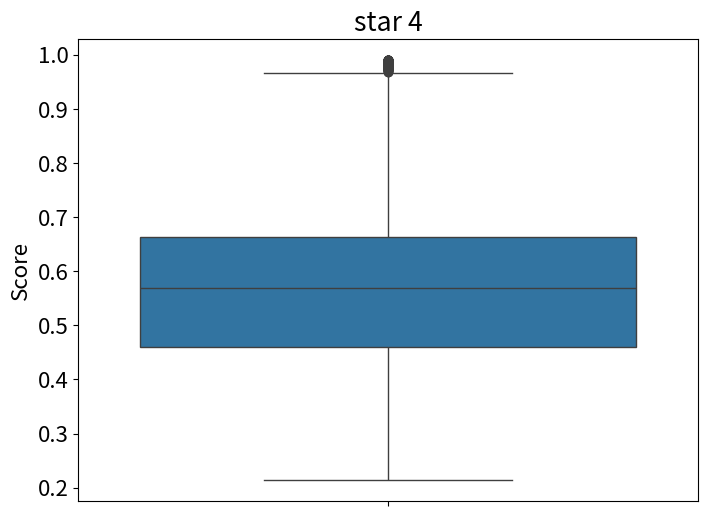

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 篩選出label為 'star 4'
star4_data = results_df[results_df['label'] == 'star 4']

# 繪製盒狀圖
plt.figure(figsize=(8, 6))
sns.boxplot(y=star4_data['score'])
plt.title('star 4')
plt.ylabel('Score')
plt.show()

In [ ]:
import pandas as pd
import jieba
from collections import Counter


# 篩選出正面情緒的句子，'star 5' 和 'star 4' 為正面
positive_sentences = results_df[results_df['label'].isin(['star 4', 'star 5'])]['sentence']

# 使用 jieba 進行分詞
words = [word for sentence in positive_sentences for word in jieba.cut(sentence) if len(word) > 1]

# 計算詞頻
word_counts = Counter(words)

# 輸出最常見的10個詞
most_common_words = word_counts.most_common(10)
print(most_common_words)


[('周處', 779), ('電影', 636), ('三害', 624), ('台灣', 482), ('桂林', 321), ('票房', 295), ('阮經天', 245), ('https', 241), ('最佳', 230), ('com', 223)]


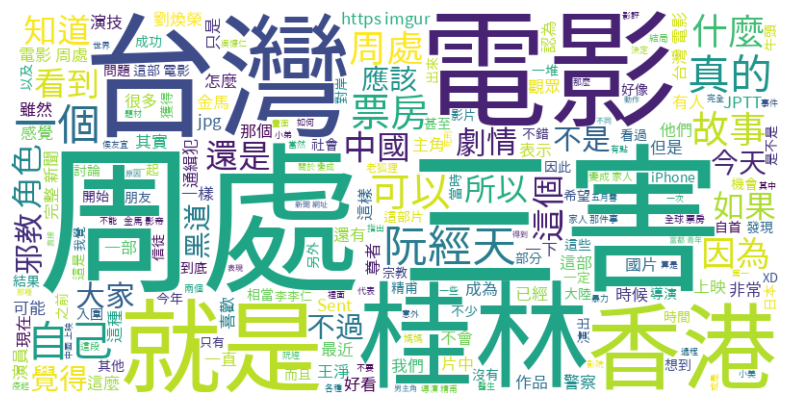

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 設定字型
FontPath = 'TaipeiSansTCBeta-Regular.ttf'

# 假設 'words' 是從 jieba 分詞得到的詞列表
words_string = ' '.join(words)  # 將所有詞合併成一個長字符串

# 創建文字雲物件
wordcloud = WordCloud(
    font_path=FontPath,
    width=800,
    height=400,
    background_color='white'  # 設置背景顏色
).generate(words_string)

# 顯示文字雲圖像
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### 4.2 Relation Extraction (RE)
使用 Huggingface 上面已經針對 RE 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/teppei727/bert-large-relation14

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("teppei727/bert-large-relation14")
model = AutoModelForSequenceClassification.from_pretrained("teppei727/bert-large-relation14", ignore_mismatched_sizes=True)

re_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 使用模型來進行 RE
text = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]
result = re_model(text)

# 輸出結果
result

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

[{'label': '[no connective]', 'score': 0.5112497210502625},
 {'label': 'Expansion.Conjunction', 'score': 0.6735779047012329}]

In [ ]:
# 建立一個新的 dataframe 來儲存結果
re_results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
re_results_df['sentence'] = en_origin_data['sentence']

# 定義一個函數來進行 RE 任務
def get_re_result(sentence):
    result = re_model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行 RE 任務
re_results_df[['label', 'score']] = en_origin_data['sentence'].apply(get_re_result)

# 輸出結果
re_results_df

注意：RE 跟 NER 一樣，不同的模型會有不同的關係型態，尤其是使用特定領域資料 fine-tune 的模型，通常會有該特定領域專有的關係型態

### 5. Text Clustering

以下使用 BERTopic 來實作 BERT-based 的 Text Clustering，並介紹 clustering-based 的主題模型<br>
BERTopic: https://maartengr.github.io/BERTopic/index.html<br>
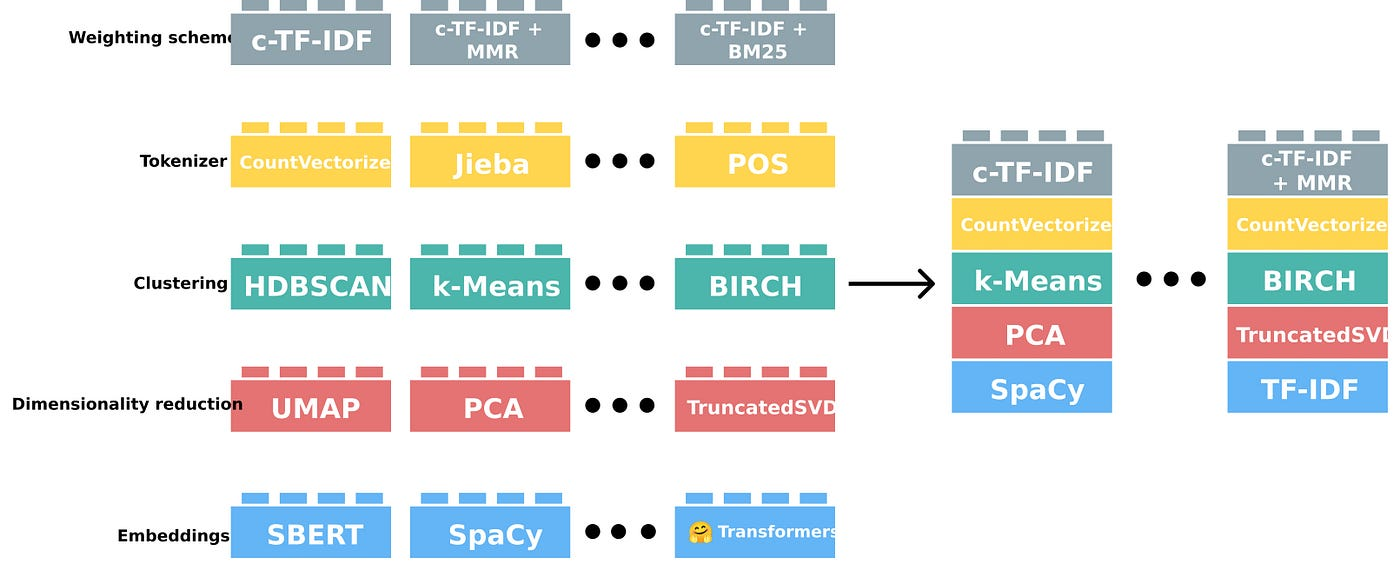

#### 5.1 基本用法介紹

In [ ]:
docs = en_origin_data['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs[:500])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,128,-1_the_of_and_you,"[the, of, and, you, it, to, in, she, not, is]","[By all that I have ever read, I am convinced ..."
1,0,46,0_you_it_not_but,"[you, it, not, but, is, did, do, that, complim...","[""Do you not think it would be a proper compli..."
2,1,42,1_bennet_mrs_mr_that,"[bennet, mrs, mr, that, said, netherfield, of,...","[""How good it was in you, my dear Mr. Bennet!,..."
3,2,35,2_bingley_mr_and_her,"[bingley, mr, and, her, the, of, in, miss, was...",[I dare say Mr. Bingley will be very glad to s...
4,3,33,3_darcy_mr_to_his,"[darcy, mr, to, his, of, the, and, at, was, with]",[Between him and Darcy there was a very steady...
5,4,29,4_of_think_single_must,"[of, think, single, must, should, is, my, you,...","[""I am astonished, my dear,"" said Mrs. Bennet,..."
6,5,29,5_he_his_and_was,"[he, his, and, was, in, to, manners, there, th...","[and turning round, he looked for a moment at ..."
7,6,22,6_jane_was_her_elizabeth,"[jane, was, her, elizabeth, she, to, and, the,...","[Elizabeth, easy and unaffected, had been list..."
8,7,18,7_eliza_dance_danced_he,"[eliza, dance, danced, he, with, you, the, mis...",[He paused in hopes of an answer; but his comp...
9,8,16,8_lucas_miss_to_the,"[lucas, miss, to, the, his, and, lady, party, ...",[They attacked him in various ways; with baref...


選第六個主題去看，可以看到前幾名的topic word

In [ ]:
topic_model.get_topic(6)

[('jane', 0.07929778003212384),
 ('was', 0.0510897009813797),
 ('her', 0.04424846546150737),
 ('elizabeth', 0.04363999900919622),
 ('she', 0.03498096395249333),
 ('to', 0.03371053607099477),
 ('and', 0.03355290516715721),
 ('the', 0.03288255995051214),
 ('by', 0.03175565362055449),
 ('at', 0.030247476298153633)]

從文本的角度去看這個文本是屬於哪個主題等相關資訊

In [ ]:
topic_model.get_document_info(docs[:500])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,﻿TPRIDE & PREJUDICE.,-1,-1_the_of_and_you,"[the, of, and, you, it, to, in, she, not, is]","[By all that I have ever read, I am convinced ...",the - of - and - you - it - to - in - she - no...,0.000000,False
1,"It is a truth universally acknowledged, that a...",4,4_of_think_single_must,"[of, think, single, must, should, is, my, you,...","[""I am astonished, my dear,"" said Mrs. Bennet,...",of - think - single - must - should - is - my ...,0.629132,False
2,However little known the feelings or views of ...,4,4_of_think_single_must,"[of, think, single, must, should, is, my, you,...","[""I am astonished, my dear,"" said Mrs. Bennet,...",of - think - single - must - should - is - my ...,0.675085,True
3,"""My dear Mr. Bennet,"" said his lady to him one...",1,1_bennet_mrs_mr_that,"[bennet, mrs, mr, that, said, netherfield, of,...","[""How good it was in you, my dear Mr. Bennet!,...",bennet - mrs - mr - that - said - netherfield ...,0.504378,False
4,Mr. Bennet replied that he had not.,1,1_bennet_mrs_mr_that,"[bennet, mrs, mr, that, said, netherfield, of,...","[""How good it was in you, my dear Mr. Bennet!,...",bennet - mrs - mr - that - said - netherfield ...,0.999433,True
...,...,...,...,...,...,...,...,...
495,Elizabeth was glad to be taken to her immediat...,6,6_jane_was_her_elizabeth,"[jane, was, her, elizabeth, she, to, and, the,...","[Elizabeth, easy and unaffected, had been list...",jane - was - her - elizabeth - she - to - and ...,0.667558,False
496,"She was not equal, however, to much conversati...",2,2_bingley_mr_and_her,"[bingley, mr, and, her, the, of, in, miss, was...",[I dare say Mr. Bingley will be very glad to s...,bingley - mr - and - her - the - of - in - mis...,0.524969,False
497,Elizabeth silently attended her.,6,6_jane_was_her_elizabeth,"[jane, was, her, elizabeth, she, to, and, the,...","[Elizabeth, easy and unaffected, had been list...",jane - was - her - elizabeth - she - to - and ...,0.685839,False
498,"When breakfast was over, they were joined by t...",-1,-1_the_of_and_you,"[the, of, and, you, it, to, in, she, not, is]","[By all that I have ever read, I am convinced ...",the - of - and - you - it - to - in - she - no...,0.000000,False


In [ ]:
topic_model.visualize_topics()

#### 5.2 Embedding model<br>
BERTopic 支援多種 embedding 模型與方法，包含基本的 Huggingface 模型，也提供了 LLM-based 的 embedding 可做選擇。<br>
更多請參考文件：https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#scikit-learn-embeddings

In [ ]:
# 使用 sentence_transformers 相關語言模型作為 embedding_model
sentence_model = SentenceTransformer("google-bert/bert-base-uncased")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（sentence_model）
embed_topic_model = BERTopic(embedding_model=sentence_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = embed_topic_model.fit_transform(docs[:500])

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
!pip install openai

In [ ]:
import openai
from bertopic.backend import OpenAIBackend

# 也可以使用 OpenAI API 來獲取性能更強大的語言模型作為 embedding_model
client = openai.OpenAI(api_key="請替換為你的 openai key")
openai_embedding_model = OpenAIBackend(client, "text-embedding-ada-002")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（openai_embedding_model）
openai_topic_model = BERTopic(embedding_model=openai_embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = openai_topic_model.fit_transform(docs[:500])

#### 5.3 Clustering model<br>
參考文件：https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html

調整 topic modeling 流程中的 clustering 算法

In [ ]:
# 使用 KMeans 作為分群算法，需要指定分群個數
cluster_model = KMeans(n_clusters=10)

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 hdbscan_model 替換為其他模型（cluster_model）
kmeans_topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, vectorizer_model=vectorizer_model)
topics, probs = kmeans_topic_model.fit_transform(docs[:500])

kmeans_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,69,0_you_it_not_do,"[you, it, not, do, is, but, that, them, to, did]","[""It will be no use to us, if twenty such shou..."
1,1,64,1_of_is_to_it,"[of, is, to, it, be, in, you, are, if, have]",[But to be candid without ostentation or desig...
2,2,58,2_the_her_and_was,"[the, her, and, was, of, to, jane, she, their,...",[By Jane this attention was received with the ...
3,3,57,3_he_and_the_was,"[he, and, the, was, to, her, had, in, his, of]",[Of this she was perfectly unaware;--to her he...
4,4,56,4_bennet_of_mrs_mr,"[bennet, of, mrs, mr, the, that, to, and, you,...","[Mr. Bennet replied that he had not., ""How goo..."
5,5,54,5_bingley_mr_the_of,"[bingley, mr, the, of, and, was, to, his, her,...","[Bingley intended it likewise, and sometimes m..."
6,6,48,6_darcy_to_lucas_mr,"[darcy, to, lucas, mr, his, the, and, of, miss...","[And taking her hand, he would have given it t..."
7,7,46,7_you_it_not_long,"[you, it, not, long, for, the, him, will, and,...","[But if _we_ do not venture, somebody else wil..."
8,8,29,8_dance_lizzy_he_eliza,"[dance, lizzy, he, eliza, you, not, with, the,...","[""You excel so much in the dance, Miss Eliza, ..."
9,9,19,9_oh_officers_the_secret,"[oh, officers, the, secret, ah, length, connec...","[""Oh!, ""Oh!, ""Oh!]"


查看 text clustering 結果

In [ ]:
topics[:10]

[6, 1, 4, 4, 4, 7, 4, 0, 5, 0]

#### 5.4 套用於中文<br>
為了套用到中文文章，各元件必須修改為支援中文的方法，主要針對 embedding model 以及 tokenizer

In [ ]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-05-10 08:06:08,745 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-10 08:06:12,179 - BERTopic - Dimensionality - Completed ✓
2024-05-10 08:06:12,181 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-10 08:06:12,201 - BERTopic - Cluster - Completed ✓
2024-05-10 08:06:12,207 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt ...
Dumping model to file cache /tmp/jieba.ua7a7fbbccac5d324cda1cbc5ec01a12e.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.ua7a7fbbccac5d324cda1cbc5ec01a12e.cache
Loading model cost 2.314 seconds.
DEBUG:jieba:Loading model cost 2.314 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2024-05-10 08:06:14,737 - BERTopic -

,Topic,Count,Name,Representation,Representative_Docs
0,-1,99,-1_ _手槍_周處_電影,"[ , 手槍, 周處, 電影, 有限, 股份, 公司, ／, 一種, 態度, 中, 通緝犯,...","[（圖／一種態度電影股份有限公司提供）, （圖／一種態度電影股份有限公司）, （圖／一種態度..."
1,0,84,0_ _三害_電影_周處,"[ , 三害, 電影, 周處, 阮經天, 金馬獎, 故事, 臉書, 作品, 導演, 蒼鷺, ...","[▲阮經天犧牲外型演出電影《周處除三害》, （圖／翻攝自錢人豪臉書）▲錢人豪（左）認為《周處..."
2,1,60,1_莊男_曹男_ _駕駛,"[莊男, 曹男, , 駕駛, 送醫, 65, 貨車, 台, 失控, 快速, 道路, 路段,...","[一時情緒失控曹男父子見狀也被莊男突如其來的舉動嚇到, 台65快速道路車禍, 台65快速道路..."
3,2,56,2_賴清德_蔡英文_ _年,"[賴清德, 蔡英文, , 年, 民進黨, 總統, 月, 任期, 馬英九, 新潮流, 機會,...","[賴清德2014年連任台南市長後, 蔡英文 賴清德都說過贊同台灣該改為內閣制, 就覺得賴清德..."
4,3,35,3_抄襲_公開_提出_,"[抄襲, 公開, 提出, , 道歉, 接觸, 實質, 內容, 證據, 相似, 司法, 權,...","[才有辦法在法律上站得住腳；若無實質相似、合理機會的接觸下, 必須依靠實質證據來釐清事實；在..."
5,4,35,4_提供_ _好看_觀察,"[提供, , 好看, 觀察, 自保, 血流, 統計, 當人, 留名, 甲上, 牠, 海鵬,...","[（甲上提供）, （UIP提供）, （海鵬提供）]"
6,5,35,5_中國_ _預告片_說,"[中國, , 預告片, 說, 想, 台灣, 最近, 前, 整個, imgur, 抵制, 應...",[只有我看到這個嗎https://i.imgur.com/P7BmXGq.jpg周處除三害上...
7,6,31,6_com_https_2023_新聞,"[com, https, 2023, 新聞, jpg, tw, 10, 完整, 08, lt...",[https://img.ltn.com.tw/Upload/ent/page/800/20...
8,7,19,7_周處_三害_ _電影院,"[周處, 三害, , 電影院, 道德, 錢人, 軟, 賣國, 貪官污吏, 豪今, 統畜, ...","[不是都說周處除三害嗎, 周處除三害, 周處除三害]"
9,8,18,8_魚虎_潭區_日月潭_紅魔鬼,"[魚虎, 潭區, 日月潭, 紅魔鬼, 珍珠, 石斑, 外來種, 生態, 潭, 入侵, 尾, ...","[日月潭遭魚虎入侵, 之後又遭紅魔鬼、珍珠石斑、魚虎等肆虐, 減少並壓制其族群數量；不少民力..."


In [ ]:
zh_topic_model.visualize_topics()

查看特定文章的主題分佈

In [ ]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


看第18篇文章的主題分佈

In [ ]:
zh_topic_model.visualize_distribution(topic_distr[18])

In [ ]:
zh_topic_model.get_topic(0)

[(' ', 0.04979343873065058),
 ('三害', 0.046833650450641535),
 ('電影', 0.044606912091059464),
 ('周處', 0.042234295879632566),
 ('阮經天', 0.04205834762067029),
 ('金馬獎', 0.034056743871157626),
 ('故事', 0.032865047153178235),
 ('臉書', 0.03088372672675671),
 ('作品', 0.026482682581058584),
 ('導演', 0.026471765765791466),
 ('蒼鷺', 0.02531232163960449),
 ('藝術', 0.02531232163960449),
 ('年', 0.02484246850571229),
 ('／', 0.02449186185767391),
 ('少年', 0.02432624562225545),
 ('錢人豪', 0.023936529005690273),
 ('▲', 0.02272680854479254),
 ('自錢', 0.02233609852957466),
 ('翻攝', 0.02233609852957466),
 ('人豪', 0.02233609852957466),
 ('男', 0.02233609852957466),
 ('最佳', 0.02233609852957466),
 ('圖', 0.022059804804826222),
 ('上映', 0.021458498229515125),
 ('台灣', 0.021458498229515125),
 ('塞納河', 0.02118614606484687),
 ('大法師', 0.02118614606484687),
 ('黃精', 0.02024985731168359),
 ('生命', 0.02024985731168359),
 ('演出', 0.02024985731168359)]

這邊去看主題0的詞彙分佈

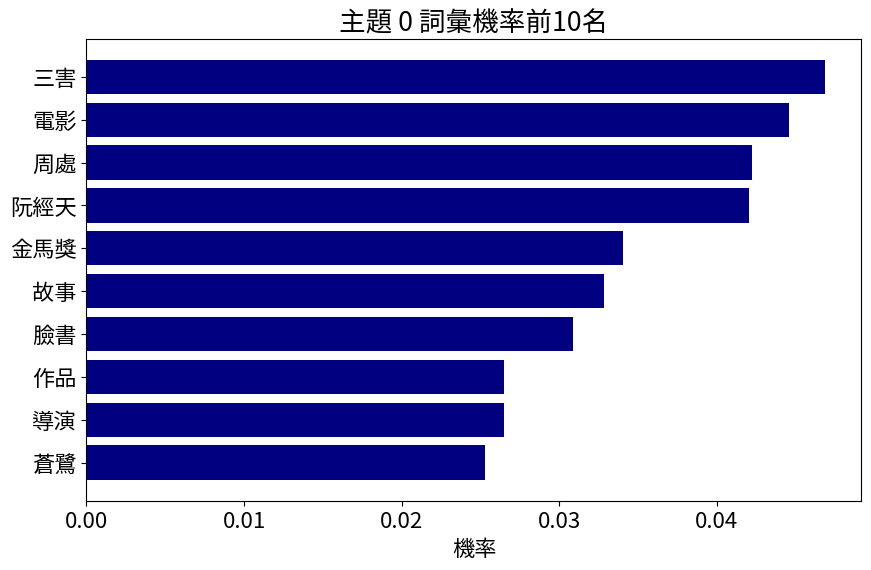

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 0
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()